# Глубокие нейросети в компьютерном зрении. Дополнительная профессиональная программа профессиональной переподготовки.
# Модуль 1.  Программирование компьютерного зрения на языке Python.

## Лабораторная работа №4  "Классификация изображений на основе метода k-ближайших соседей".

Выполнил студент Мовенко Константин группы ИС/б-21-2-о.

В блокноте исследуются свойства KNN-классификатора изображений. Классификация в соответствии с методом kNN предполагает выполнение двух этапов:
- обучения классификатора, в ходе которого классификатор просто запоминает входные изображения;
- тестирование, во время которого классификатор относит каждое тестовое изображение к ближайшему из запомненных на этапе обучения изображений и выдает его метку.

Параметр k является гиперпараметром и его значение определяется в процессе кросс-валидации.

Цель этого блокнота: реализовать указанные этапы,  изучить  базовую схему классификации изображений, кросс-валидации и сформировать навыки разработки эффективного векторизованного кода.



In [1]:
from __future__ import print_function
import random
import numpy as np
from pcv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# Команды для того, чтобы изображения matplotlib отображались в блокноте, а не в новом окне.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # установка размера графика по умолчанию
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Напоминаем, что загрузка и описание датасета CIFAR-10 приведено в блокноте лабораторной работы №3.

In [2]:
# Загрузка данных из базы CIFAR-10.
cifar10_dir = 'files\cifar-10-batches-py'

# Очистка переменных для предотвращения повторной загрузки данных (что может вызвать проблемы с памятью)
try:
    del X_train, y_train
    del X_test, y_test
    print('Очистка ранее загруженных данных')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Для проверки работоспособности распечатаем размер обучающих и тестовых данных.
print('Форма массива обучающих данных: ', X_train.shape)
print('Форма массива обучающих меток:', y_train.shape)
print('Форма массива тестовых данных:', X_test.shape)
print('Форма массива тестовых меток:', y_test.shape)

Форма массива обучающих данных:  (50000, 32, 32, 3)
Форма массива обучающих меток: (50000,)
Форма массива тестовых данных: (10000, 32, 32, 3)
Форма массива тестовых меток: (10000,)


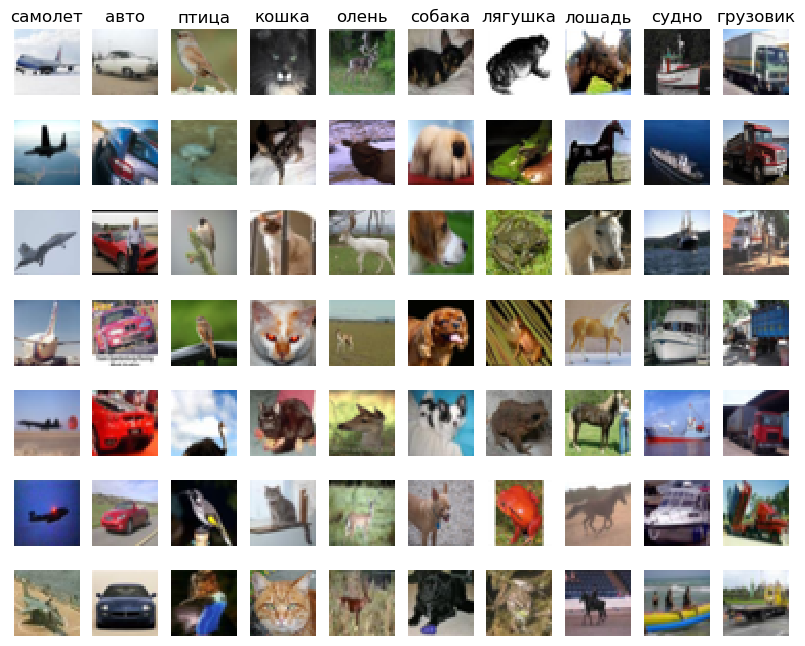

In [3]:
# Визуализируем некоторые изображения из набора данных.
# Покажем несколько примеров изображений из каждого класса.
classes = ['самолет', 'авто', 'птица', 'кошка', 'олень', 'собака', 'лягушка', 'лошадь', 'судно', 'грузовик']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Сделаем небольшие выборки обучающих и тестовых изображений для сокращения времени выполнения кода задания
num_training = 5000                 # число обучающего примеров
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500                      # число тестовых примеров
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Преобразуем матрицы изображений в векторы
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)  # печать размеров обучающего и тестового массивов

(5000, 3072) (500, 3072)


In [6]:
from pcv.k_nearest_neighbor import KNearestNeighbor

# Создадим экземпляр классификатора kNN.
# Напомним, что обучение классификатора kNN не выполняется: классификатор просто запоминает данные.
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Теперь мы хотим  классифицировать тестовые данные с помощью классификатора kNN. Напомним, что этот процесс можно разбить на два этапа:

1. Сначала мы должны вычислить расстояния между каждым тестовым примером и всеми обучающими примерами.
2. С учетом этих расстояний для каждого тестового примера (изображения) необходимо найти k ближайших соседей (запомненных примеров) и выбрать метку, которая имеет наибольшее число голосов (чаще встречается).

Давайте начнем с вычисления матрицы расстояния между всеми обучающими и тестовыми примерами. Например, если есть **Ntr** обучающих (training) примеров и **Nte** тестовых (test) примеров, то мы должны получить матрицу, размером  **Nte x Ntr**, где каждый элемент (i,j) является расстоянием между i-м тестовым и  j-м обучающим примером.

Сначала откройте файл `pcv/k_nearest_neighbor.py` и реализуйте функцию `compute_distances_two_loops`, которая использует (весьма неэффективные) вложенные циклы по всем парам (тестовых и обучаемых) примеров и вычисляет матрицу расстояний по одному элементу за одну итерацию.

In [7]:
# Откройте pcv/k_nearest_neighbor.py и реализуйте функцию compute_distances_two_loops.

# Протестируйте Вашу реализацию (вычисления займут 1-2 минуты! Подождите!)
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


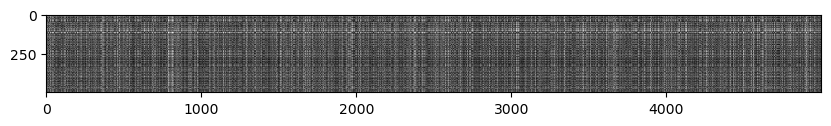

In [8]:
# Мы можем визуализировать матрицу расстояний: каждая строка соответствует одному тестовому изображению и
# его расстояниям до обучающих изображений
plt.imshow(dists, interpolation='none')
plt.show()

**Вопрос #1:** Обратите внимание на структуру видимых образов в матрице расстояний, в которой некоторые строки или столбцы видны ярче. (Обратите внимание, что при стандартной цветовой схеме по умолчанию черный цвет указывает на небольшие расстояния, а белый - на большие расстояния)

- Что в данных является причиной ярких строк?
- Что является причиной ярких столбцов?

**Ваш ответ**: *Заполняйте здесь.*

Причина ярких строк - наличие тестовых изображений, крайне непохожих на большую часть обучающей выборки. По этой причине для него трудно определить класс.

Причина ярких столбцов - наличие изображений в обучающей выборке, не похожих на большую часть тестовых изображений. По этой причине они практически бесполезны при классификации данных указанной выборки.

In [9]:
# Теперь реализуйте функцию predict_labels и выполните код ниже
# Мы используем k=1, что соответствует одному ближайшему соседу
y_test_pred = classifier.predict_labels(dists, k=1)

# Вычислите точность классификации - долю правильно предсказанных меток
num_correct = np.sum(y_test_pred == y_test) # число правильно предсказанных меток
accuracy = float(num_correct) / num_test    # точность
print('Правильно предсказанные/число тестовых примеров =  %d / %d => точность: %f' % (num_correct, num_test, accuracy))

Правильно предсказанные/число тестовых примеров =  137 / 500 => точность: 0.274000


Вы должны получить точность (accuracy) примерно `27%`. Теперь попробуйте использовать большие `k`, скажем `k = 5`:

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Правильно предсказанные/число тестовых примеров =  %d / %d => точность: %f' % (num_correct, num_test, accuracy))

Правильно предсказанные/число тестовых примеров =  143 / 500 => точность: 0.286000


Вы должны получить точность немного больше, чем при `k = 1`.

**Вопрос 2**: Мы можем также использовать и другие метрики расстояния, например L1.
Эффективность kNN-классификатора, использующего расстояние L1, не изменится, если
(выберите те ответы, которые верны):
1. Данные предварительно обрабатываются путем вычитания среднего значения.
2. Данные предварительно обрабатываются путем вычитания среднего значения и деления на стандартное отклонение.
3. Ось координат для данных вращается.
4. Ничего из перечисленного.

*Ваш выбор*: 1, 2

*Ваше объяснение*: Предварительная обработка данных путем вычитания среднего значения не изменит эффективность классификатора. Поскольку вычитание среднего значения применяется одинаково ко всем точкам данных, оно не изменяет относительные расстояния между точками.

Предварительная обработка данных путем вычитания среднего значения и деления на стандартное отклонение также не изменит эффективность классификатора. Эти действия масштабируют данные, но не меняют их относительные расстояния.

Вращение оси координат для данных изменит относительные расстояния между точками, и поэтому эффективность классификатора может измениться. Если ось координат повернута, то расстояния будут вычисляться по измененным осям.

In [11]:
# Теперь повысим скорость вычисления матрицы расстояний путем частичной векторизации одного цикла.
# Реализуйте функцию compute_distances_one_loop c одним циклом и выполните код ниже
dists_one = classifier.compute_distances_one_loop(X_test)

# Чтобы убедиться, что наша векторная реализация верна, мы должны проверить
# совпадение результатов с предыдущей версией функции вычисления расстояний. 
# Существует много способов проверки аналогичности матриц; одной из самых простых
# является норма Фробениуса. Норма Фробениуса двух матриц - квадратный
# корень из суммы квадратов различий всех элементов; другими словами, необходимо
# преобразовать матрицы в векторы и вычислить евклидово расстояние между ними.

# вычисления займут 1-2 минуты! Подождите!
difference = np.linalg.norm(dists - dists_one, ord='fro') # вычисление нормы Фробениуса
print('Отличие матриц расстояний: %f' % (difference, ))
if difference < 0.001:
    print('Хорошо! Матрицы расстояний одинаковы')
else:
    print('Что-то не так! Матрицы расстояний отличаются')

Отличие матриц расстояний: 0.000000
Хорошо! Матрицы расстояний одинаковы


In [12]:
# Теперь реализуйте полностью векторизованную версию функции compute_distances_no_loops,
# вычисляющуб матрицу расстояний без циклов и выполните код этой ячейки
dists_two = classifier.compute_distances_no_loops(X_test)

# проверьте, что матрица расстояний для этого случая совпадает с ранее вычисленными матрицами
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Отличие матриц расстояний: %f' % (difference, ))
if difference < 0.001:
    print('Хорошо! Матрицы расстояний одинаковы')
else:
    print('Что-то не так! Матрицы расстояний отличаются')

Отличие матриц расстояний: 0.000000
Хорошо! Матрицы расстояний одинаковы


In [13]:
# Теперь сравним время выполнения трех функций, вычисляющих матрицы расстояний. 
# Определим вспомогательную функцию, которая вычисляет время выполнения некоторой функции f
# и используем её для оценки времени выполнения каждой из трех упомянутых функций
def time_function(f, *args):
    """
    Вызывает функцию f с параметром args и возвращает выполнения время (в секундах)
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

# вычисления займут время! Подождите!
two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Версия с двумя циклами выполнилась за %f секунды' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('Версия с одним циклом выполнилась за %f секунды' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('Версия без циклов выполнилась за %f секунды' % no_loop_time)

# Вы должны увидеть значительное сокращение времени для полностью векторизованного кода

Версия с двумя циклами выполнилась за 30.191019 секунды
Версия с одним циклом выполнилась за 53.422899 секунды
Версия без циклов выполнилась за 0.248080 секунды


### Кросс-валидация

Мы реализвали kNN-классификатор, но мы установили значение k = 5 произвольно. Теперь мы определим наилучшее значение этого гиперпараметра, используя кросс-валидацию.

In [14]:
# Разобьем наши данные на 5 частей (папок) и реализуем кросс-валидацию
num_folds = 5
# Будем выбирать значения k из следующего списка
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# ЗАДАНИЕ:                                                                     #
# Разделите обучающие данные на папки. После разделения "папки" X_train_folds  #
# и y_train_folds должны быть списками длины fold_len, где                    #
# y_train_folds[i] - это вектор меток для примеров из X_train_folds[i].        #
# Совет: используйте функцию numpy array_split.                                #
################################################################################

fold_len = X_train.shape[0] // num_folds
fold_row = X_train.shape[1]

# формируем список индексов, относительно которых будем разбивать данные
split_list = [(i + 1) * fold_len for i in range(num_folds)]

# разбиваем обучающие данные на папки
X_train_folds = np.split(X_train, split_list)
y_train_folds = np.split(y_train, split_list)

################################################################################
#                                 КОНЕЦ ВАШЕГО КОДА                            #
################################################################################

# Построим словарь, содержащий точности классификации для разных значений k.
# После кросс-валидации запись в словаре k_to_accuracies[k] должна быть списком
# длины num_folds, содержащим разные значения точности, которые были вычислены 
# при соотвествующем k.
k_to_accuracies = {}

################################################################################
# ЗАДАНИЕ:                                                                     #
# Выполните кросс-валидацию, чтобы найти наилучшее значение k. Для каждого     #
# возможного значения k, запускайте алгоритм k-ближайшего соседа num_folds раз,#
# где в каждом случае вы используете для обучения все папки, кроме одной,      #
# которая используется как валидационная. Сохраняйте точность для всех папок и #
# всех значений k в словаре k_to_accuracies.                                   #
################################################################################

for k in k_choices:
    temp_accuracy = np.zeros(num_folds)
    
    for i in range(num_folds):
        X_val = X_train_folds[i]
        y_val = y_train_folds[i]
        flag = 0
        for j in range(num_folds):
            if (j != i):
                if flag == 0:
                    X_tr = X_train_folds[j]
                    y_tr = y_train_folds[j]
                    flag = 1
                else:
                    np.vstack([X_tr, X_train_folds[j]])
                    np.concatenate([y_tr, y_train_folds[j]])
                    
        classifier = KNearestNeighbor()
        classifier.train(X_tr, y_tr)
        
        # вычисляем матрицу расстояний по отношению к изображениям из валидационной папки
        dists = classifier.compute_distances_no_loops(X_val)
        
        # выполняем предсказание меток изображений из валидационной папки
        y_val_pred = classifier.predict_labels(dists, k=k)
        
        # вычисляем число корректно клиссифицированных изображений
        num_correct = np.sum(y_val_pred == y_val)
        
        # вычисляем точность на i-ом шаге кросс-валидации
        temp_accuracy[i] = float(num_correct) / fold_len
    
    # добавляем в словарь k_to_accuracies[k] массив из точностей классификации на каждом шаге кросс-валидации
    k_to_accuracies[k] = temp_accuracy

    # вычисляем среднюю точность классификации по всем шагам кросс-валидации
    mean_acc = np.sum(temp_accuracy) / num_folds
    print('Для k = %d | --> средняя точность: %f' % (k, mean_acc))

################################################################################
#                                КОНЕЦ ВАШЕГО КОДА                             #
################################################################################

# Печать вычисленных точностей из словаря k_to_accuracies
print('\nВывод точностей для каждого k и каждого шага кросс-валидации:')
for k in sorted(k_to_accuracies):
    step=0
    for accuracy in k_to_accuracies[k]:
        step+=1
        print('k = %d, шаг=%d, точность = %f' % (k, step, accuracy))

Для k = 1 | --> средняя точность: 0.246000
Для k = 3 | --> средняя точность: 0.249200
Для k = 5 | --> средняя точность: 0.265800
Для k = 8 | --> средняя точность: 0.257200
Для k = 10 | --> средняя точность: 0.256800
Для k = 12 | --> средняя точность: 0.259400
Для k = 15 | --> средняя точность: 0.249400
Для k = 20 | --> средняя точность: 0.251400
Для k = 50 | --> средняя точность: 0.240400
Для k = 100 | --> средняя точность: 0.229800

Вывод точностей для каждого k и каждого шага кросс-валидации:
k = 1, шаг=1, точность = 0.244000
k = 1, шаг=2, точность = 0.234000
k = 1, шаг=3, точность = 0.256000
k = 1, шаг=4, точность = 0.251000
k = 1, шаг=5, точность = 0.245000
k = 3, шаг=1, точность = 0.236000
k = 3, шаг=2, точность = 0.248000
k = 3, шаг=3, точность = 0.255000
k = 3, шаг=4, точность = 0.248000
k = 3, шаг=5, точность = 0.259000
k = 5, шаг=1, точность = 0.269000
k = 5, шаг=2, точность = 0.268000
k = 5, шаг=3, точность = 0.261000
k = 5, шаг=4, точность = 0.267000
k = 5, шаг=5, точность =

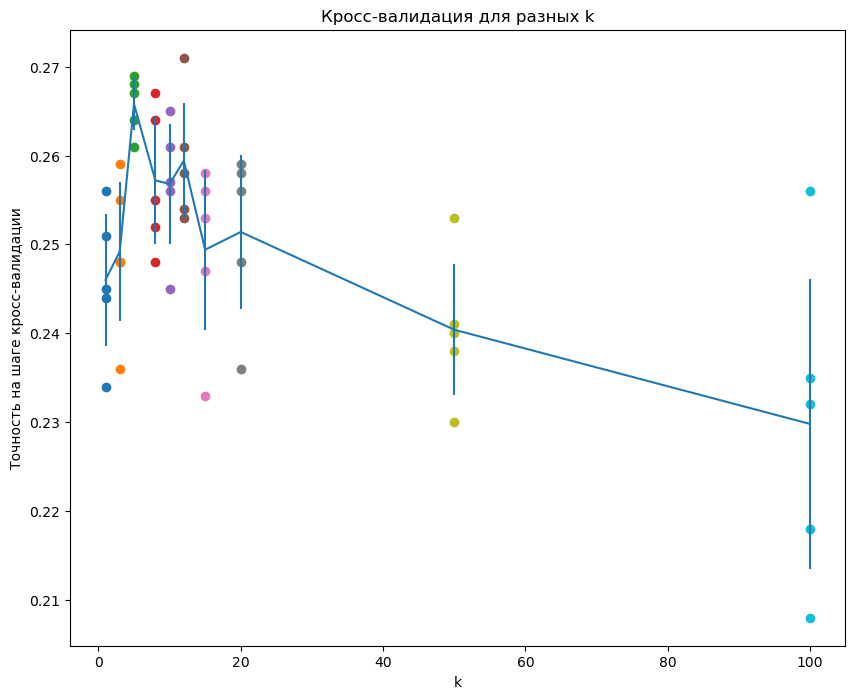

In [15]:
# графическое представление результатов 
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# построение линии тренда с диапазонами ошибок, которые соответствуют стандартным отклонениям
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Кросс-валидация для разных k')
plt.xlabel('k')
plt.ylabel('Точность на шаге кросс-валидации')
plt.show()

In [16]:
# Основываясь на результатах кросс-вылидации, выберите наилучшее значение  k,
# переобучите классификатор, используя все обучающие данные, проверьте его на тестовых
# данных. Вы должны быть получить точность примерно 28% на тестовых данных.

best_k = 5

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Вычисление и отображение точности
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Правильно предсказанные/число тестовых примеров =  %d / %d => точность: %f' % (num_correct, num_test, accuracy))

Правильно предсказанные/число тестовых примеров =  143 / 500 => точность: 0.286000


**Вопрос #3**
Какие из следующих утверждений относительно kNN классификатора верны?
Выбрать те ответы, которые подходят.
1. Ошибка *обучения* 1-NN классификатора всегда будет меньше, чем ошибка 5-NN классификатора.
2. Ошибка *тестирования* 1-NN классификатора всегда будет меньше, чем ошибка 5-NN классификатора.
3. Граница решения классификатора k-NN является линейной.
4. Время, необходимое для классификации тестового примера kNN-классификатором, растет с размером обучающего множества.
5. Ничего из вышеперечисленного.


*Ваш выбор*: 1, 4

*Ваше объяснение*: 

1 - верно, т.к. 1-NN классификатор использует только ближайший сосед для классификации, поэтому он будет иметь ошибку обучения 0 (то есть он будет идеально классифицировать обучающие примеры).

2 - неверно, т.к. дополнительные метрики 5-NN классификатора могут скорректировать результат, найденный по наименьшему значению разницы (наименьшая разница != верная классификация).

3 - неверно, т.к. форма границы решения kNN-классификатора зависит в большей мере от данных и выбранной метрики расстояния.

4 - верно, т.к. при классификации тестового примера kNN-классификатор должен вычислить расстояния до всех примеров в обучающем множестве, что занимает время. 